In [17]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter
import matplotlib.colors as colors

## 1. Useful Functions

In [2]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    new_specs = []
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions

#import raman data 
def Raman_data_loader(filename):

    with h5py.File( filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [8]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [3]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((0, 0), (x_pad , x_pad), (y_pad, y_pad)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]  

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

## Import LIBS Dataset

(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


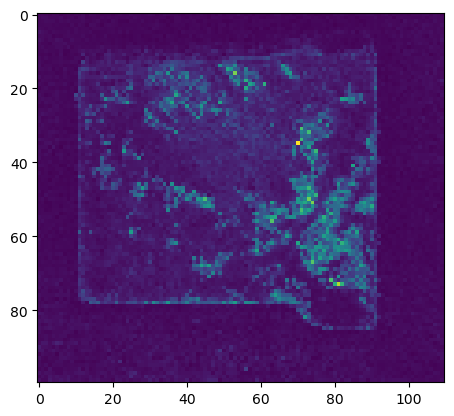

In [7]:
filename = ["340_map.h5", "355_map.h5", "370_map.h5"]

spectrums = []
for fname in filename:
    spectrum, wavelengths, positions = read_data_map(fname)
    spectrums.append(spectrum)

libs_spectrums = np.array(spectrums)
libs_wavelengths = wavelengths.flatten()

fig,ax=subplots()
ax.imshow(libs_spectrums[0,:,:,find_index(libs_wavelengths,568.77)])

## Import Raman Dataset

In [11]:
filename = ["20231211_ 927.h5", "20231211_1046.h5", "20231211_1152.h5"]

raman_spectrums = []
for fname in filename:
    spectrum_raman, raman_wavelengths, exp_properties = Raman_data_loader(fname)
    raman_spectrums.append(spectrum_raman)
raman_spectrums=np.array(raman_spectrums)

In [27]:
raman_spectrums = raman_spectrums[:, :, :, 31:328]
raman_wavelengths = np.array(raman_wavelengths[31:328])

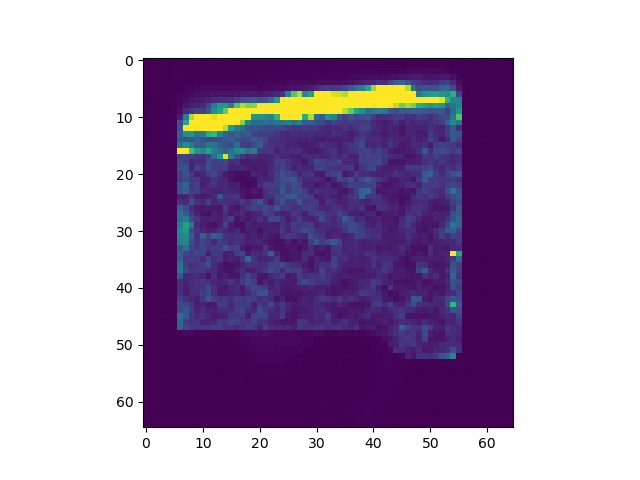

In [28]:
fig,ax=subplots()
ax.imshow(raman_spectrums[0,:,:,find_index(raman_wavelengths,464)])

## Align the maps

### function

In [14]:
class align:
    def __init__(
            self, 
            image,
            image_to_transform,
            figsize = (12, 6),lognorm=True
    ):
        """
        Variable Initialization. Takes as input two 2D datasets (or RGB images)
        we wish to align

        Parameters:
            image: array_like (grayscale or RGB)
                Reference image
            image_to_transform: array_like (grayscale or RGB)
                Image we wish to transform
            figsize: list
                Size of the plotting area
        """
        self.S = None
        self.V = None
        self.U = None
        self.T = None
        self.centroid = None
        self.point_cloud_image = []
        self.point_cloud_image_to_tranform = []
        self.new_data = None
        self.x_size, self.y_size = image.shape[0], image.shape[1]
        self.image_to_tranform = image_to_transform

        ### Plotting ###
        self.fig, self.ax = subplots(1, 3, figsize = figsize)

        if lognorm:
            self.ax[0].imshow(image, interpolation = 'gaussian', norm=colors.LogNorm(vmin=10, vmax=image.max()),origin='lower')
        else:
            self.ax[0].imshow(image, interpolation = 'gaussian',origin='lower')

        self.plot1, = self.ax[0].plot([], [], color = 'r', marker = 'o', ms = 5)
        self.ax[0].set_title('Reference Image')

        self.ax[1].imshow(image_to_transform, interpolation = 'gaussian', origin = 'lower')
        self.plot2, = self.ax[1].plot([], [], color = 'r', marker = 'o', ms = 5)
        self.ax[1].set_title('Image to Tansform')

        self.fig.canvas.mpl_connect('button_press_event', self._on_click)

    def _right_click(self, event):
        """
        Point Selection
        """
        if event.inaxes == self.ax[0]: #warrants that we are clicking the correct axes
            self.point_cloud_image.append([event.xdata, event.ydata])
            self.plot1.set_data([row[0] for row in self.point_cloud_image], [row[1] for row in self.point_cloud_image])
    
        if event.inaxes == self.ax[1]: #warrants that we are clicking the correct axes
            self.point_cloud_image_to_tranform.append([event.xdata, event.ydata])
            self.plot2.set_data([row[0] for row in self.point_cloud_image_to_tranform], [row[1] for row in self.point_cloud_image_to_tranform])
    
    def _left_click(self, event):
        """
        Alignment action
        """
        if len(self.point_cloud_image) != len(self.point_cloud_image_to_tranform):
            print("The number of points selected should be the same for both images")
        else:
            left_plot = np.array(self.point_cloud_image)
            right_plot = np.array(self.point_cloud_image_to_tranform)

            # Rough Alignment
            self.centroid, self.T, self.U, self.S, self.V = self._svd_params(left_plot, right_plot)
            #Transform the data
            self.transform(self.image_to_tranform)
            t_p = np.array([self.T + b @ self.U @ np.diag(self.S) @ self.V for b in (left_plot - self.centroid)])
            self.ax[2].imshow(self.new_data, interpolation = 'gaussian', origin = 'lower')
            self.ax[1].plot(t_p[:, 0], t_p[:, 1], color = 'k', marker = 'o')



    def transform(self, data):
        """
        Uses the found parameters to transform an image or an entire
        data cube. The transformed dataset with be stored in the variable 
        new_data.
        
        Parameters:
            data: array_like

        Returns:
            -----
        """
        if len(data.shape) == 2:
            self.new_data = np.zeros((self.x_size, self.y_size))
        elif data.shape[-1] == 3:
            self.new_data = np.zeros((self.x_size, self.y_size, data.shape[2]), dtype = int)
        else:
            self.new_data = np.zeros((self.x_size, self.y_size, data.shape[2]))

        for i in range(0, self.y_size):
            for j in range(0, self.x_size):
                vec = self.T + np.array([i, j] - self.centroid) @ self.U @ np.diag(self.S) @ self.V
                new_i, new_j = int(vec[0]), int(vec[1])
                try:
                    if len(data.shape) == 2:
                        self.new_data[j, i] = data[new_j, new_i]
                    else:
                        self.new_data[j, i, :] = data[new_j, new_i]
                except:
                    pass
            
    def _svd_params(self, A, B):
        """
        Align centroids and use SVD to find transformation
        parameters. Very similar to a regression.

        Parameters:
            A: array_like
                point cloud we wish to align
            B: array_like
                reference point cloud

        Returns:
            Rotation: array_like
                3D rotation matrix 
            Scale: float
                Scaling factor
            Translation: array_like
                Translation vector
        """
        assert A.shape == B.shape
        
        A_center = np.mean(A, axis = 0)
        B_center = np.mean(B, axis = 0)

        centered_A = A - A_center
        centered_B = B - B_center

        X = np.linalg.inv(centered_A.T @ centered_A) @ centered_A.T @ centered_B
        U, S, V = np.linalg.svd(X)
        return A_center, B_center, U, S, V
    
    def _on_click(self, event):
        """
        Button press actions
        """
        if event.button == MouseButton.RIGHT:
            self._right_click(event)

        elif  event.dblclick:
            self._left_click(event)

### map alignment

In [69]:
raman_map=raman_spectrums[0,:,:,find_index(raman_wavelengths,464)]
libs_map=libs_spectrums[0,:,:,find_index(libs_wavelengths,568.77)]

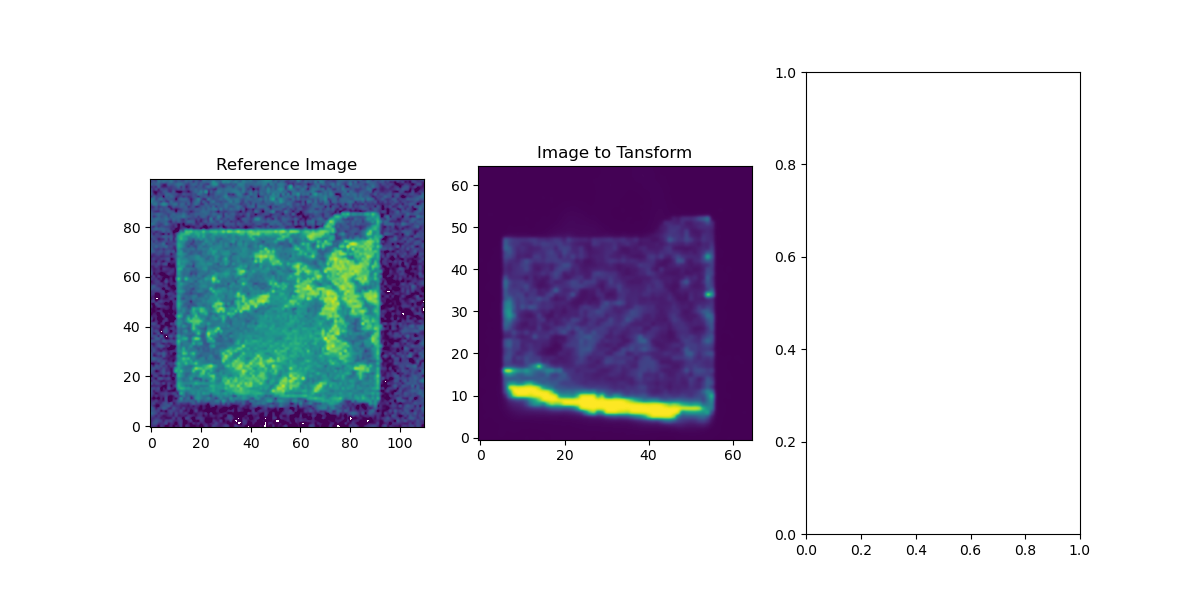

In [76]:
%matplotlib widget
aligner=align(libs_map,raman_map)

## Raman Analysis

In [43]:
lam = 1e2
p = 1e-1

pro_data = np.array(raman_spectrums)

for k in range(0, pro_data.shape[0]):
    for i in tqdm(range(0, pro_data.shape[1])):
        for j in range(0, pro_data.shape[2]):
            spec = 1 * pro_data[k, i,j, :]
            pro_data[k,i,j,:] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)
pro_data_sum = np.array(pro_data)

for sp in range(pro_data_sum.shape[0]):
    spe = pro_data_sum[sp].reshape(pro_data_sum.shape[1]*pro_data_sum.shape[2], -1)
    norm = np.array([spe[i, :]/np.sum(spe[i, :]) for i in range(0, spe.shape[0])]).reshape(pro_data_sum.shape[1], pro_data_sum.shape[2], -1)
    print(norm.shape)
    pro_data_sum[sp] = norm

scaled_pro = []
for i in range(0, pro_data_sum.shape[0]):
    min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[:, :, :, wv].min())/(pro_data_sum[:, :, :, wv].max() - pro_data_sum[:, :, :, wv].min()) 
                               for wv in range(pro_data_sum.shape[-1])])
    scaled_pro.append(min_max_scaled)


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:51<00:00,  1.27it/s]


(65, 65, 297)
(65, 65, 297)
(65, 65, 297)


In [44]:
scaled_pro_raman=np.array(scaled_pro)

In [46]:
scaled_pro_raman.shape

(3, 297, 65, 65)

### Gaussian Pyramid

In [47]:
scaled_pro_raman=scaled_pro_raman[:,:,0:64,0:64]

In [49]:
# w_exposedness = gauss(scaled_pro, 0.2, np.mean(scaled_pro))
w_exposedness = gauss(scaled_pro_raman, 0.2, 0.5)
weights_norm = w_exposedness.copy()

new_data = np.zeros(w_exposedness.shape[1:])

for i in tqdm(range(w_exposedness.shape[1])):
    for j in range(w_exposedness.shape[2]):
        for k in range(w_exposedness.shape[3]):
            sum = np.sum(w_exposedness[:, i, j, k])
            weights_norm[:, i, j, k] = (w_exposedness[:, i, j, k]/sum)
            new_data[i, j, k] = (scaled_pro_raman[0, i, j, k]*w_exposedness[0, i, j, k]/sum + 
                                 scaled_pro_raman[1, i, j, k]*w_exposedness[1, i, j, k]/sum + 
                                 scaled_pro_raman[2, i, j, k]*w_exposedness[2, i, j, k]/sum)
            
weights_norm = np.array(weights_norm)

new_data1_raman = np.zeros(scaled_pro_raman.shape[1:])
n_layers = 6

#x_padding_1 = 16
#x_padding_2 = 15
#y_padding_1 = 16
#y_padding_2 = 15
x_padding = 0
y_padding = 0

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro_raman[:, j], x_padding,y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding,y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1_raman[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [00:01<00:00, 152.43it/s]


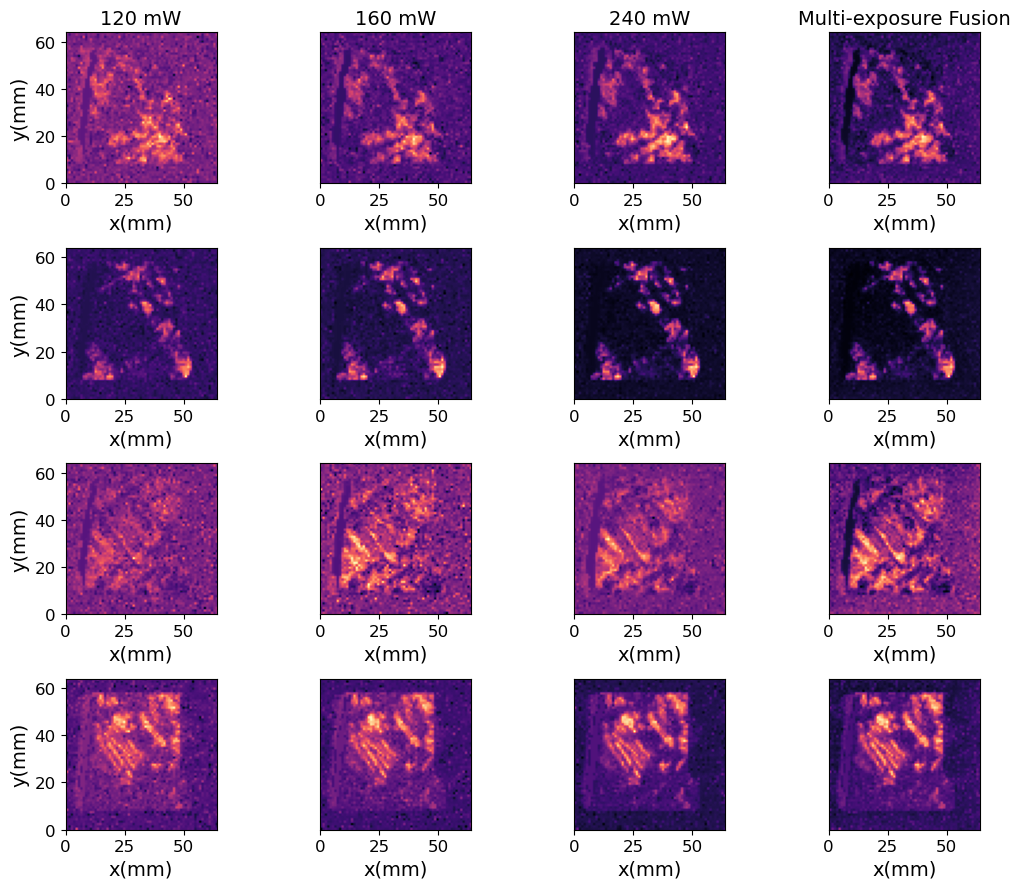

In [51]:
%matplotlib inline
fig, ax = subplots(4, 4, figsize = (11, 9))

wl = [509, 464, 490, 705]
Lx=64
Ly=64
#fig.suptitle(f'Wn: {wl[0]}'+r' cm$^{-1}$',fontsize=16)
cmap='magma'
for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('120 mW',fontsize=14)
    axs.imshow(scaled_pro_raman[0, find_index(raman_wavelengths, wl[w])].T,extent=[0,Lx,0,Ly],cmap=cmap)
    #axs.set_ylabel(f'Wn: {wl[w]}'+r' cm$^{-1}$', fontsize=14)
    axs.grid(False)
    axs.set_xlabel('x(mm)',fontsize=14)
    axs.set_ylabel('y(mm)',fontsize=14)
    axs.tick_params(labelsize=12)

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('160 mW',fontsize=14)
    axs.imshow(scaled_pro_raman[1, find_index(raman_wavelengths, wl[w])].T,extent=[0,Lx,0,Ly],cmap=cmap)
    axs.grid(False)
    axs.tick_params(labelsize=12)
    axs.set_xlabel('x(mm)',fontsize=14)
    axs.set_ylabel('y(mm)',fontsize=14)
    axs = ax[w, 2]
    if w == 0:
        axs.set_title('240 mW',fontsize=14)
    axs.imshow(scaled_pro_raman[2, find_index(raman_wavelengths, wl[w])].T,extent=[0,Lx,0,Ly],cmap=cmap)
    axs.grid(False)
    axs.tick_params(labelsize=12)
    axs.set_xlabel('x(mm)',fontsize=14)
    axs.set_ylabel('y(mm)',fontsize=14)
    axs = ax[w, 3]
    if w == 0:
        axs.set_title('Multi-exposure Fusion',fontsize=14)
    axs.imshow(new_data1_raman[find_index(raman_wavelengths, wl[w])].T,extent=[0,Lx,0,Ly],cmap=cmap)
    axs.grid(False)
    axs.set_xlabel('x(mm)',fontsize=14)
    axs.set_ylabel('y(mm)',fontsize=14)
    axs.tick_params(labelsize=12)

    
for w in range(len(wl)):
    for i in range(4):
        axs = ax[w, i]
        if i!=0:
            axs.set_yticks([])
            axs.set_ylabel('')

fig.tight_layout()

### feature selection

In [138]:
final_mask_raman=np.transpose(new_data1_raman,axes=(1,2,0))
import pandas as pd

minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1],
    'Background':[733.1]}



mineral_list = list(minerals.keys())


features_raman = []
radius = 2

for i,mineral in enumerate(mineral_list):
    wn=find_index(raman_wavelengths,minerals[mineral][0])
    new_array = final_mask_raman[:,:,wn-radius:wn+radius].mean(axis=-1)
    #features.append(new_array)#/np.max(new_array))
    features_raman.append( ( new_array - np.min(new_array) ) / (np.max(new_array)-np.min(new_array)))
    
features_raman = np.transpose(np.array(features_raman),axes=(1,2,0))
features_raman = features_raman.reshape([features_raman.shape[0]*features_raman.shape[1],features_raman.shape[2]])

initial_mineral_list = mineral_list

In [122]:
features_raman.shape

(4096, 5)

## LIBS analysis

In [54]:
pro_data = np.array(libs_spectrums.copy())
pro_data_sum = np.array(pro_data)

for sp in range(pro_data_sum.shape[0]):
    spe = pro_data_sum[sp].reshape(pro_data_sum.shape[1]*pro_data_sum.shape[2], -1)
    norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(pro_data_sum.shape[1], pro_data_sum.shape[2], -1)
    print(norm.shape)
    pro_data_sum[sp] = norm
scaled_pro = []

sg = 0.5

for i in tqdm(range(0, pro_data_sum.shape[0])):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.array([ (gaussian_filter(pro_data_sum[i, :, :, wv], sigma = sg) - gaussian_filter(pro_data_sum[i, :, :, wv], sigma = sg).min())/
                                                (gaussian_filter(pro_data_sum[i, :, :, wv], sigma = sg).max() - gaussian_filter(pro_data_sum[i, :, :, wv], sigma = sg).min())
                               for wv in range(pro_data_sum.shape[-1])])
    scaled_pro.append(min_max_scaled)

scaled_pro_libs = np.array(scaled_pro)


(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:16<00:00, 45.50s/it]


### Gaussian Pyramid

In [57]:

w_exposedness = gauss(scaled_pro_libs, 0.2, 0.5)
weights_norm = w_exposedness.copy()
sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/sum
            
weights_norm = np.array(weights_norm)
print('calculated weights')

new_data1_libs = np.zeros(scaled_pro_libs.shape[1:])
n_layers = 7

# Padding deve ser numero de base 2 mais proximo, e.g., 110 passa a 128,
# padding é de 18, portanto x_padding seria 9

x_padding = 14
y_padding = 9

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro_libs[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1_libs[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

calculated weights


100%|████████████████████████████████████████████████████████████████████████████| 16384/16384 [03:56<00:00, 69.42it/s]


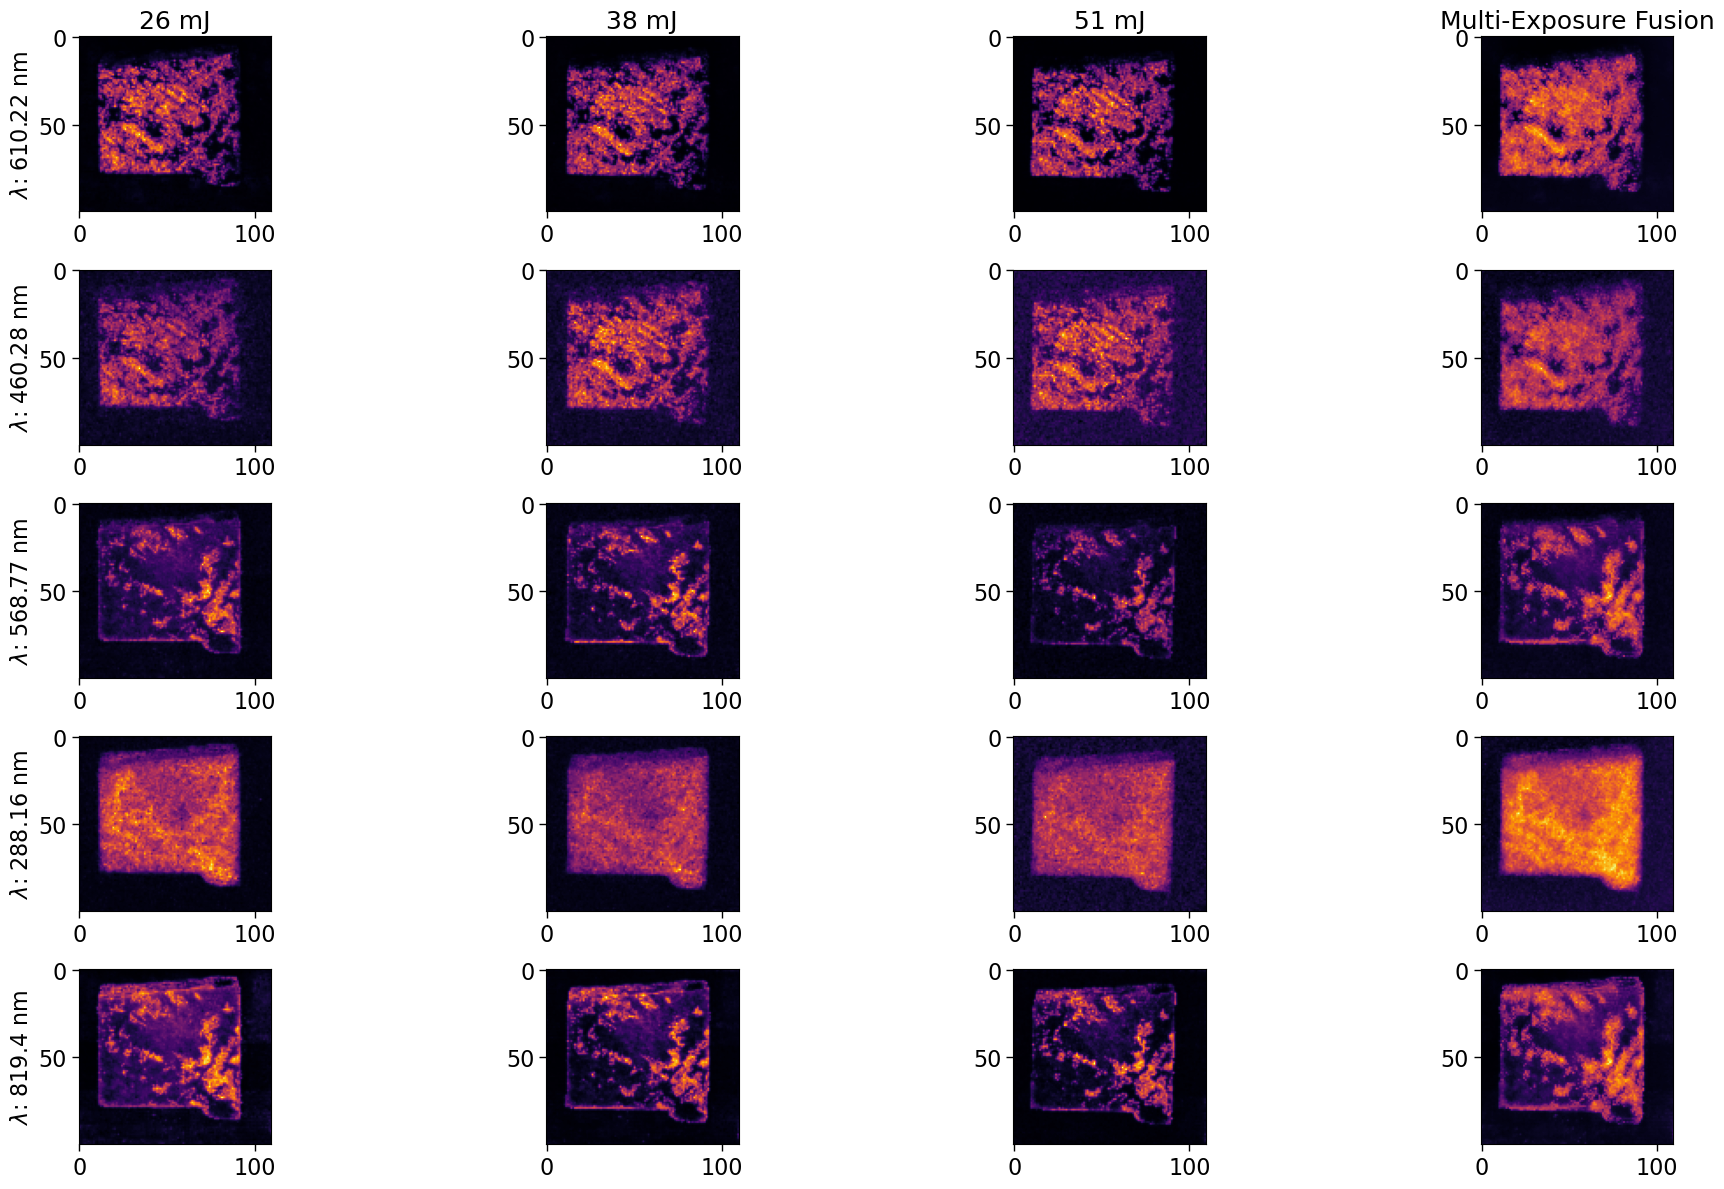

In [59]:
%matplotlib inline
fig, ax = subplots(5, 4, figsize = (20, 12))

wl = [610.22, 460.28, 568.77, 288.16, 819.40]


for w in range(0,len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('26 mJ', fontsize = 18)
    axs.imshow(scaled_pro_libs[0, find_index(libs_wavelengths, wl[w])], cmap = 'inferno')
    axs.set_ylabel(r'$\lambda$: ' + f'{wl[w]}'+' nm', fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1,labelsize=16)
    axs.grid(False)

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('38 mJ', fontsize = 18)
    axs.imshow(scaled_pro_libs[1, find_index(libs_wavelengths, wl[w])], cmap = 'inferno')
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1,labelsize=16)
    axs.grid(False)

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('51 mJ', fontsize = 18)
    axs.imshow(scaled_pro_libs[2, find_index(libs_wavelengths, wl[w])], cmap = 'inferno')

    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1,labelsize=16)
    axs.grid(False)

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('Multi-Exposure Fusion', fontsize = 18)
    axs.imshow(new_data1_libs[find_index(libs_wavelengths, wl[w])], cmap = 'inferno')
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1,labelsize=16)
    axs.grid(False)

fig.tight_layout()

### feature extraction

In [61]:
wl = [460.28, 288.16, 568.77, 237.23]
features_libs = np.array([new_data1_libs[find_index(libs_wavelengths, wl[w])] for w in range(len(wl))])

## Alinhar os mapas das features

In [140]:
print(features_raman.shape)
print(features_libs.shape)

(4096, 5)
(4, 100, 110)


In [141]:
features_raman=np.transpose(features_raman,axes=(1,0))
features_raman=features_raman.reshape(64,64,-1)

In [142]:
raman_f=[]
features_raman=features_raman.reshape(-1,64,64)
f_raman=[]
for i in tqdm(range(5)): 
    aligner.transform(features_raman[i,:,:])
    aligned_map = aligner.new_data
    f_raman.append(aligned_map)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


In [143]:
f_raman=np.array(f_raman)
f_raman.shape

(5, 100, 110)

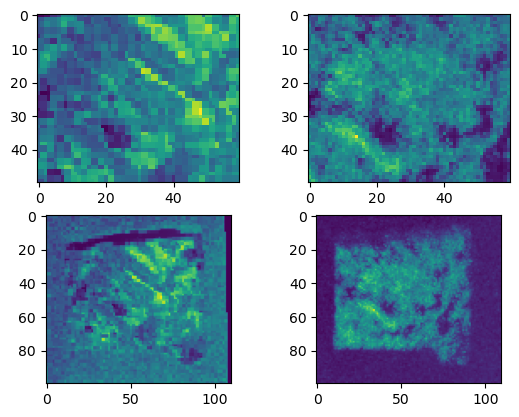

In [144]:
%matplotlib inline
fig,ax=subplots(2,2)
ax[0,0].imshow(f_raman[0,20:70,20:80])
ax[0,1].imshow(features_libs[0,20:70,20:80])

ax[1,0].imshow(f_raman[0,:,:])
ax[1,1].imshow(features_libs[0,:,:])

In [145]:
f_raman_cut=np.transpose(f_raman[:,20:70,20:80],axes=(1,2,0))
f_raman_cut=f_raman_cut.reshape(50*60,-1)
f_libs_cut=np.transpose(features_libs[:,20:70,20:80],axes=(1,2,0))
f_libs_cut=f_libs_cut.reshape(50*60,-1)

## Classificadores

In [146]:
import sklearn
from sklearn import cluster

### Raman

In [147]:
f_raman_cut.shape

(3000, 5)

In [148]:
minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1]}

mineral_list = list(minerals.keys())
n_clusters = 4

# Cluster centers already initialized to match those of the predicted features
clusters_init = [ [1,0,0,0,0], 
                 [0,1,0,0,0],
                 [0,0,1,0,0],
                 [0,0,0,1,0]
                ]


model = sklearn.cluster.KMeans(n_clusters=n_clusters, init = np.array(clusters_init), random_state=100)
model.fit(f_raman_cut)
predictions = model.predict(f_raman_cut)

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


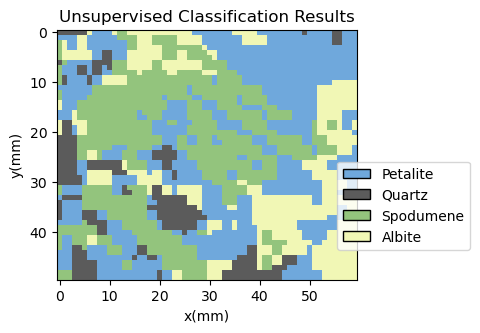

In [159]:
fig,ax = subplots(1,1,figsize=[5,4])
colors = ['#6fa8dc','#5b5b5b','#93c47d','#F1F7B5']
cmp1 = ListedColormap(colors[:n_clusters])
ax.imshow(predictions.reshape(50,60),
           cmap=cmp1,interpolation='nearest')

hls=[]
for color,cluster in zip(colors,mineral_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('Unsupervised Classification Results')
ax.legend(handles=hls,bbox_to_anchor=(1.4, 0.5))
ax.set_xlabel(r'x(mm)')
ax.set_ylabel(r'y(mm)')
fig.tight_layout()

### LIBS

In [165]:
wl = [460.28, 288.16, 237.23,568.77]
######Li       Si       Al     Na


init=np.array([[1,1,1,0],
               [0,1,0,0],
               [1,1,1,0],
               [0,1,1,1]])
model1 = KMeans(n_clusters = 4, init = init*0.5)

labels_libs = model1.fit_predict(f_libs_cut)

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


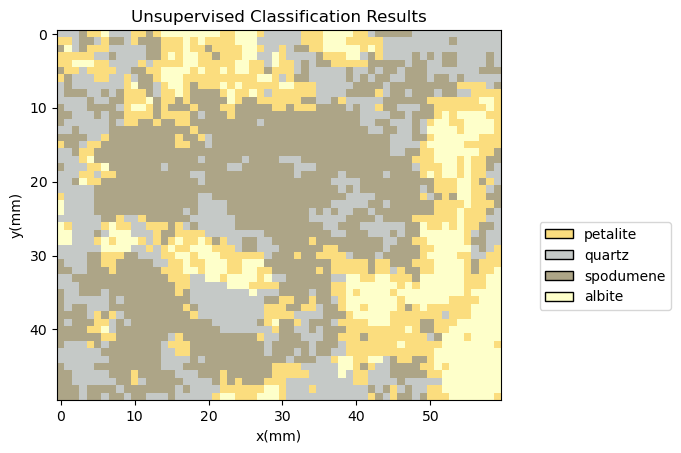

In [167]:
subplots()

nx, ny = 50,60
colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
cmp_libs = ListedColormap(colors)
xlabel('x(mm)')
ylabel('y(mm)')
imshow(labels_libs.reshape(nx, ny)[::, ::], cmap = cmp_libs, interpolation = 'none')
mineral_list2=['petalite','quartz','spodumene','albite']
hls=[]
for color,cluster in zip(colors,mineral_list2):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

title('Unsupervised Classification Results')
legend(handles=hls,bbox_to_anchor=(1.4, 0.5))

## matriz de confusão

In [169]:
from sklearn import metrics

libs_confusion = metrics.confusion_matrix(predictions,labels_libs)

In [170]:
libs_confusion = np.array(libs_confusion, dtype = float)
for i in range(libs_confusion.shape[0]):
    libs_confusion[i] /= np.sum(libs_confusion[i])

[Text(0, 0, 'petalite'),
 Text(0, 1, 'quartz'),
 Text(0, 2, 'spodumene'),
 Text(0, 3, 'albite')]

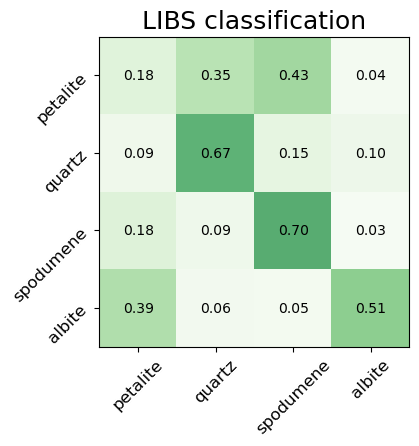

In [176]:
%matplotlib inline
fig, axs = subplots(1, 1, figsize = (4, 8))
# ax.imshow(libs_confusion, cmap = 'Greens')

ax = axs
ax.set_title('LIBS classification', fontsize = 18)
ax.imshow(libs_confusion, cmap = 'Greens', alpha = 0.8, vmax = 1, vmin = 0)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)


In [177]:
 sklearn.metrics.accuracy_score(predictions, labels_libs, normalize=True)

0.458